## Vesuvius Challenge - Ink Detection Training Notebook

### Setup

In [1]:
# # Pretrained weights
# # ref - https://github.com/kenshohara/3D-ResNets-PyTorch
# !pip install gdown
# !gdown 1Nb4abvIkkp_ydPFA9sNPT1WakoVKA8Fa

# # Utility packages for reading and visualizing volumes
# !pip install zarr imageio-ffmpeg

# save model checkpoints
!mkdir ./ckpts

In [2]:
import os
import gc
import sys
import zarr
import random
import imageio
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import Video

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda import amp
from torch.utils.data import Dataset, DataLoader

sys.path.append("./resnet3d")
from resnet3d import generate_model

### Config

In [3]:
LR = 1e-4
EPOCHS = 70
BATCH_SIZE = 32
CROP_SIZE = 256
Z_START = 24
Z_DIMS = 16
TRAIN_FRAGMENTS = ["1", "3"]
TEST_FRAGMENT = "2"

### Load data

In [4]:


FRAGMENTS_ZARR = {
    "1" : zarr.open("/home/viktor/Documents/kaggle/vesuvius-challenge/kaggle-data/train-1.zarr", mode="r"),
    "2" : zarr.open("/home/viktor/Documents/kaggle/vesuvius-challenge/kaggle-data/train-2.zarr", mode="r"),
    "3" : zarr.open("/home/viktor/Documents/kaggle/vesuvius-challenge/kaggle-data/train-3.zarr", mode="r")
}

FRAGMENTS_SHAPE = {k : v.mask.shape for k, v in FRAGMENTS_ZARR.items()}

### Visualise input

In [5]:
fragment = FRAGMENTS_ZARR["1"]
x, y = 2000, 2000

fragment_cropped = fragment.surface_volume[y:y+CROP_SIZE, x:x+CROP_SIZE, Z_START:Z_START+Z_DIMS]
imageio.mimwrite("fragment_crop.mp4", fragment_cropped.transpose(2, 0, 1), "ffmpeg")
Video("fragment_crop.mp4", height=256, width=256)

Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. C

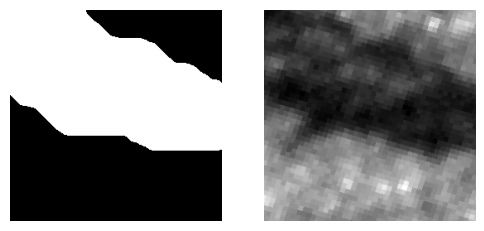

In [6]:
mask_cropped = fragment.truth[y:y+CROP_SIZE, x:x+CROP_SIZE]
ir_cropped = fragment.infrared[y:y+CROP_SIZE, x:x+CROP_SIZE]

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.imshow(mask_cropped, cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(ir_cropped, cmap="gray")
plt.axis("off")
plt.show()

In [7]:
del fragment, fragment_cropped, mask_cropped, ir_cropped
gc.collect()

4093

### Dataloaders

In [8]:
# import albumentations as A
# from albumentations.pytorch import ToTensorV2

# class VesuviusTrain(Dataset):
#     def __init__(self, fragments):
#         self.fragments = fragments
#         self.xys = []
        
#         for fragment in fragments:
#             H, W = FRAGMENTS_SHAPE[fragment]
#             for y in range(0, H-CROP_SIZE+1, CROP_SIZE):
#                 for x in range(0, W-CROP_SIZE+1, CROP_SIZE):
#                     self.xys.append((fragment, x, y, W, H))
        
#         train_aug_list = [
#                 # A.RandomResizedCrop(
#                 #     size, size, scale=(0.85, 1.0)),
#                 A.HorizontalFlip(p=0.5),
#                 A.VerticalFlip(p=0.5),
#                 A.RandomBrightnessContrast(p=0.75),
#                 A.CoarseDropout(max_holes=1, max_width=int(CROP_SIZE * 0.1), max_height=int(size * 0.1), 
#                                 mask_fill_value=0, p=0.5),
#                 A.ShiftScaleRotate(p=0.75),
#                 A.Rotate(limit=90, p=0.9), 
#                 A.OneOf([
#                         A.GaussNoise(var_limit=[10, 50]),
#                         A.GaussianBlur(),
#                         A.MotionBlur(),
#                         ], p=0.4),
#                 A.GridDistortion(num_steps=1, distort_limit=0.3, p=0.5),
                
#                 A.Cutout(max_h_size=int(size * 0.6),
#                          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
#                 A.Normalize(
#                     mean= [0] * Z_DIMS,
#                     std= [1] * Z_DIMS
#                 ),
#                 ToTensorV2(transpose_mask=True),
#             ]
        
        
        
#     def __getitem__(self, i):
#         fragment, x1, y1, W, H = self.xys[i]
#         z1, z2 = Z_START, Z_START+Z_DIMS
        
#         x_offset = random.randint(-32 if x1 != 0 else 0, 32)
#         y_offset = random.randint(-32 if y1 != 0 else 0, 32)
        
#         x1 += x_offset
#         y1 += y_offset
        
#         x2 = x1 + CROP_SIZE
#         y2 = y1 + CROP_SIZE
        
#         if x2 > W:
#             x1 -= x_offset
#             x2 -= x_offset
            
#         if y2 > H:
#             y1 -= y_offset
#             y2 -= y_offset
        
#         frag_crop = FRAGMENTS_ZARR[fragment].surface_volume[y1:y2, x1:x2, z1:z2]
#         mask_crop = FRAGMENTS_ZARR[fragment].truth[y1:y2, x1:x2]
        
#         if random.random() > 0.5:
#             frag_crop = np.flip(frag_crop, axis=1).copy()
#             mask_crop = np.flip(mask_crop, axis=1).copy()

#         frag_crop = torch.from_numpy(frag_crop.astype(np.float32)).unsqueeze(0).permute(0, 3, 1, 2)
#         frag_crop = frag_crop/65535.0
#         frag_crop = (frag_crop - 0.45)/0.225
        
#         mask_crop = torch.from_numpy(mask_crop.astype(np.float32)).unsqueeze(0)
        
        
        
        
        
        
        
        
#         return frag_crop, mask_crop

#     def __len__(self):
#         return len(self.xys)

In [9]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

class VesuviusTrain(Dataset):
    def __init__(self, fragments):
        self.fragments = fragments
        self.xys = []
        
        for fragment in fragments:
            H, W = FRAGMENTS_SHAPE[fragment]
            for y in range(0, H-CROP_SIZE+1, CROP_SIZE):
                for x in range(0, W-CROP_SIZE+1, CROP_SIZE):
                    surface = FRAGMENTS_ZARR[fragment].surface_volume[y:y+CROP_SIZE, x:x+CROP_SIZE, 0]
                    if np.sum(surface) / (CROP_SIZE * CROP_SIZE) > 0.2:
                        self.xys.append((fragment, x, y, W, H))
        
        self.train_aug_list = [
                # A.RandomResizedCrop(
                #     size, size, scale=(0.85, 1.0)),
                
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                
                # A.RandomBrightnessContrast(p=0.75),
                A.CoarseDropout(max_holes=1, max_width=int(CROP_SIZE * 0.1), max_height=int(CROP_SIZE * 0.1), 
                                mask_fill_value=0, p=0.5),
                # A.ShiftScaleRotate(p=0.75),
                
                A.Rotate(limit=90, p=0.9), 
                
                # A.OneOf([
                #         A.GaussNoise(var_limit=[0.01, 0.05]),
                #         A.GaussianBlur(blur_limit=(3, 5), sigma_limit=0),
                #         A.MotionBlur(blur_limit=3),
                #         ], p=0.8),
                # A.GridDistortion(num_steps=1, distort_limit=0.1, p=0.5),
                # A.MultiplicativeNoise(per_channel=True, multiplier=(0.95, 1.05)),
                
                # A.Cutout(max_h_size=int(CROP_SIZE * 0.2),
                #          max_w_size=int(CROP_SIZE * 0.2), num_holes=1, p=1.0),
                
                ToTensorV2(transpose_mask=True),
            ]
        
        # Create the augmentation pipeline
        self.augmentations = A.Compose(self.train_aug_list)
        
        
        
    def __getitem__(self, i):
        fragment, x1, y1, W, H = self.xys[i]
        z1, z2 = Z_START, Z_START+Z_DIMS
        
        x_offset = random.randint(-128 if x1 != 0 else 0, 128)
        y_offset = random.randint(-128 if y1 != 0 else 0, 128)
        
        x1 += x_offset
        y1 += y_offset
        
        x2 = x1 + CROP_SIZE
        y2 = y1 + CROP_SIZE
        
        if x2 > W:
            x1 -= x_offset
            x2 -= x_offset
            
        if y2 > H:
            y1 -= y_offset
            y2 -= y_offset
        
        frag_crop = FRAGMENTS_ZARR[fragment].surface_volume[y1:y2, x1:x2, z1:z2]
        mask_crop = FRAGMENTS_ZARR[fragment].truth[y1:y2, x1:x2]
        
        # if random.random() > 0.5:
        #     frag_crop = np.flip(frag_crop, axis=1).copy()
        #     mask_crop = np.flip(mask_crop, axis=1).copy()

        # Perform train augmentations

        frag_crop = frag_crop/65535.0
        
        
        # Apply the augmentations
        augmented = self.augmentations(image=frag_crop, mask=mask_crop)

        # Separate the image and mask
        frag_crop, mask_crop = augmented["image"], augmented["mask"]

        # normalize
        
        # frag_crop = (frag_crop - 0.45)/0.225
        
        frag_crop = frag_crop.unsqueeze(0) 
        mask_crop = mask_crop.float().unsqueeze(0)
        
        
        return frag_crop, mask_crop

    def __len__(self):
        return len(self.xys)

In [10]:
class VesuviusVal(Dataset):
    def __init__(self, fragment):
        self.fragment = FRAGMENTS_ZARR[fragment]
        self.xys = []
        
        H, W = FRAGMENTS_SHAPE[fragment]
        for y in range(0, H-CROP_SIZE+1, CROP_SIZE):
            for x in range(0, W-CROP_SIZE+1, CROP_SIZE):
                self.xys.append((x, y))
                
    def __getitem__(self, i):
        x1, y1 = self.xys[i]
        x2, y2 = x1+CROP_SIZE, y1+CROP_SIZE
        z1, z2 = Z_START, Z_START+Z_DIMS
        
        frag_crop = self.fragment.surface_volume[y1:y2, x1:x2, z1:z2]
        mask_crop = self.fragment.truth[y1:y2, x1:x2]

        frag_crop = torch.from_numpy(frag_crop.astype(np.float32)).unsqueeze(0).permute(0, 3, 1, 2)
        frag_crop = frag_crop/65535.0
        # frag_crop = (frag_crop - 0.45)/0.225
        
        mask_crop = torch.from_numpy(mask_crop.astype(np.float32)).unsqueeze(0)
        return frag_crop, mask_crop, torch.tensor([x1, y1, x2, y2], dtype=torch.int32)

    def __len__(self):
        return len(self.xys)

In [11]:
dataset_train = VesuviusTrain(TRAIN_FRAGMENTS)
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, num_workers=2,
                              shuffle=True, pin_memory=True, drop_last=True)
n_train = len(dataloader_train)

dataset_valid = VesuviusVal(TEST_FRAGMENT)
dataloader_valid = DataLoader(dataset_valid, batch_size=BATCH_SIZE, num_workers=2,
                              shuffle=False, pin_memory=True, drop_last=False)
n_valid = len(dataloader_valid)

In [12]:
i = random.randint(0, len(dataset_train))
i=30
img = dataset_train[i][0]
img.min(), img.max()

(tensor(0.0006, dtype=torch.float64), tensor(1., dtype=torch.float64))

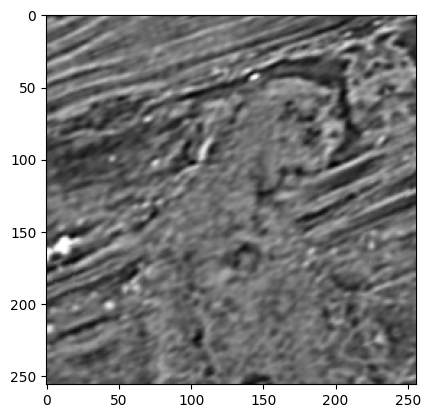

In [13]:
img_2 = img.squeeze(0).permute(1, 2, 0).numpy()
plt.imshow(img_2[:, :, 0], cmap="gray")

### Model
* Encoder is a 3D ResNet model. The architecture has been modified to remove temporal downsampling between blocks.
* A 2D decoder is used for predicting the segmentation map.
* The encoder feature maps are average pooled over the Z dimension before passing it to the decoder.

In [14]:
class Decoder(nn.Module):
    def __init__(self, encoder_dims, upscale):
        super().__init__()
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(encoder_dims[i]+encoder_dims[i-1], encoder_dims[i-1], 3, 1, 1, bias=False),
                nn.BatchNorm2d(encoder_dims[i-1]),
                nn.ReLU(inplace=True)
            ) for i in range(1, len(encoder_dims))])

        self.logit = nn.Conv2d(encoder_dims[0], 1, 1, 1, 0)
        self.up = nn.Upsample(scale_factor=upscale, mode="bilinear")

    def forward(self, feature_maps):
        for i in range(len(feature_maps)-1, 0, -1):
            f_up = F.interpolate(feature_maps[i], scale_factor=2, mode="bilinear")
            f = torch.cat([feature_maps[i-1], f_up], dim=1)
            f_down = self.convs[i-1](f)
            feature_maps[i-1] = f_down

        x = self.logit(feature_maps[0])
        mask = self.up(x)
        return mask


class SegModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = generate_model(model_depth=34, n_input_channels=1)
        self.decoder = Decoder(encoder_dims=[64, 128, 256, 512], upscale=4)
        
    def forward(self, x):
        feat_maps = self.encoder(x)
        feat_maps_pooled = [torch.mean(f, dim=2) for f in feat_maps]
        pred_mask = self.decoder(feat_maps_pooled)
        return pred_mask
    
    def load_pretrained_weights(self, state_dict):
        # Convert 3 channel weights to single channel
        # ref - https://timm.fast.ai/models#Case-1:-When-the-number-of-input-channels-is-1
        conv1_weight = state_dict['conv1.weight']
        state_dict['conv1.weight'] = conv1_weight.sum(dim=1, keepdim=True)
        print(self.encoder.load_state_dict(state_dict, strict=False))

In [15]:
model = SegModel()
model.load_pretrained_weights(torch.load("/home/viktor/Documents/kaggle/vesuvius-challenge/experiments/3D-resnet/r3d18_K_200ep.pth")["state_dict"])
model = nn.DataParallel(model, device_ids=[0])

model = model.cuda()

_IncompatibleKeys(missing_keys=['layer1.2.conv1.weight', 'layer1.2.bn1.weight', 'layer1.2.bn1.bias', 'layer1.2.bn1.running_mean', 'layer1.2.bn1.running_var', 'layer1.2.conv2.weight', 'layer1.2.bn2.weight', 'layer1.2.bn2.bias', 'layer1.2.bn2.running_mean', 'layer1.2.bn2.running_var', 'layer2.2.conv1.weight', 'layer2.2.bn1.weight', 'layer2.2.bn1.bias', 'layer2.2.bn1.running_mean', 'layer2.2.bn1.running_var', 'layer2.2.conv2.weight', 'layer2.2.bn2.weight', 'layer2.2.bn2.bias', 'layer2.2.bn2.running_mean', 'layer2.2.bn2.running_var', 'layer2.3.conv1.weight', 'layer2.3.bn1.weight', 'layer2.3.bn1.bias', 'layer2.3.bn1.running_mean', 'layer2.3.bn1.running_var', 'layer2.3.conv2.weight', 'layer2.3.bn2.weight', 'layer2.3.bn2.bias', 'layer2.3.bn2.running_mean', 'layer2.3.bn2.running_var', 'layer3.2.conv1.weight', 'layer3.2.bn1.weight', 'layer3.2.bn1.bias', 'layer3.2.bn1.running_mean', 'layer3.2.bn1.running_var', 'layer3.2.conv2.weight', 'layer3.2.bn2.weight', 'layer3.2.bn2.bias', 'layer3.2.bn2.run

In [16]:
x = torch.randn(5, 1, 16, 256, 256).cuda()
with torch.no_grad():
    y = model(x)
y.shape

torch.Size([5, 1, 256, 256])

### Competition metric (F0.5 Score)

In [17]:
# ref - https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
def fbeta_score(preds, targets, threshold, beta=0.5, smooth=1e-5):
    preds_t = torch.where(preds > threshold, 1.0, 0.0).float()
    y_true_count = targets.sum()
    
    ctp = preds_t[targets==1].sum()
    cfp = preds_t[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

### Training

In [18]:
scaler = amp.GradScaler()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR,
                                                steps_per_epoch=10, epochs=EPOCHS//10,
                                                pct_start=0.1)

In [19]:
gt_mask = torch.from_numpy(np.asarray(FRAGMENTS_ZARR[TEST_FRAGMENT].truth)).float().cuda()
gt_shape = FRAGMENTS_SHAPE[TEST_FRAGMENT]

In [20]:
import logging

logging.basicConfig(filename="training_log.txt", level=logging.INFO)


In [21]:
fbeta_best = 0.0
for epoch in range(1, EPOCHS+1):
    model.train()
    cur_lr = f"LR : {scheduler.get_last_lr()[0]:.2E}"
    pbar_train = enumerate(dataloader_train)
    pbar_train = tqdm(pbar_train, total=n_train, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
    mloss_train, mloss_val, val_metric = 0.0, 0.0, 0.0

    




    for i, (fragments, masks) in pbar_train:
        fragments, masks = fragments.cuda().half(), masks.cuda().half()
        
        
        optimizer.zero_grad()
        with amp.autocast():
            pred_masks = model(fragments)
            loss = criterion(pred_masks, masks)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            mloss_train += loss.detach().item()

        gpu_mem = f"Mem : {torch.cuda.memory_reserved() / 1E9:.3g}GB"
        pbar_train.set_description(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{EPOCHS}", gpu_mem, cur_lr,
                                                              f"Loss: {mloss_train / (i + 1):.4f}"))
        
    scheduler.step()
    model.eval()
    pbar_val = enumerate(dataloader_valid)
    pbar_val = tqdm(pbar_val, total=n_valid, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
    final_pred_mask = torch.zeros(gt_shape, dtype=torch.float32, device='cuda')
    
    for i, (fragments, masks, xys) in pbar_val:
        fragments, masks = fragments.cuda(), masks.cuda()
        
        with torch.no_grad():
            pred_masks = model(fragments)
            mloss_val += criterion(pred_masks, masks).item()
            pred_masks = torch.sigmoid(pred_masks)
        
        for j, xy in enumerate(xys):
            final_pred_mask[xy[1]:xy[3], xy[0]:xy[2]] = pred_masks[j, 0]

        pbar_val.set_description(("%10s") % (f"Val Loss: {mloss_val / (i+1):.4f}"))
    
    for threshold in np.arange(0.2, 0.85, 0.05):
        fbeta = fbeta_score(final_pred_mask, gt_mask, threshold)
        print(f"Threshold : {threshold:.2f}\tFBeta : {fbeta:.6f}")
        
        if fbeta_best < fbeta:
            fbeta_best = fbeta
            torch.save(model.module.state_dict(), f"./ckpts/resnet18_3d_seg_best_{fbeta_best:.4f}.pt")
    
    
    if epoch >= 10:
        torch.save(model.module.state_dict(), f"./ckpts/resnet18_3d_seg_epoch_{epoch}.pt")

    # if epoch == 30:
    #     break

    print()

Epoch 1/70  Mem : 17.6GB  LR : 4.00E-06  Loss: 0.6148: 100%|██████████| 28/28 [00:17<00:
Val Loss: 0.6029: 100%|██████████| 66/66 [00:19<00:00,  3.41it/s]                       


Threshold : 0.20	FBeta : 0.148009
Threshold : 0.25	FBeta : 0.148019
Threshold : 0.30	FBeta : 0.151307
Threshold : 0.35	FBeta : 0.171233
Threshold : 0.40	FBeta : 0.194936
Threshold : 0.45	FBeta : 0.209657
Threshold : 0.50	FBeta : 0.191437
Threshold : 0.55	FBeta : 0.030774
Threshold : 0.60	FBeta : 0.000179
Threshold : 0.65	FBeta : 0.000000
Threshold : 0.70	FBeta : 0.000000
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000



Epoch 2/70  Mem : 22GB  LR : 1.04E-05  Loss: 0.5637: 100%|██████████| 28/28 [00:17<00:00
Val Loss: 0.5813: 100%|██████████| 66/66 [00:19<00:00,  3.40it/s]                       


Threshold : 0.20	FBeta : 0.151035
Threshold : 0.25	FBeta : 0.155626
Threshold : 0.30	FBeta : 0.162514
Threshold : 0.35	FBeta : 0.164251
Threshold : 0.40	FBeta : 0.141634
Threshold : 0.45	FBeta : 0.065587
Threshold : 0.50	FBeta : 0.008684
Threshold : 0.55	FBeta : 0.000487
Threshold : 0.60	FBeta : 0.000016
Threshold : 0.65	FBeta : 0.000000
Threshold : 0.70	FBeta : 0.000000
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000



Epoch 3/70  Mem : 22GB  LR : 2.80E-05  Loss: 0.5195: 100%|██████████| 28/28 [00:17<00:00
Val Loss: 0.5142: 100%|██████████| 66/66 [00:19<00:00,  3.35it/s]                       


Threshold : 0.20	FBeta : 0.153578
Threshold : 0.25	FBeta : 0.169069
Threshold : 0.30	FBeta : 0.190377
Threshold : 0.35	FBeta : 0.206894
Threshold : 0.40	FBeta : 0.218927
Threshold : 0.45	FBeta : 0.219279
Threshold : 0.50	FBeta : 0.180469
Threshold : 0.55	FBeta : 0.081193
Threshold : 0.60	FBeta : 0.006166
Threshold : 0.65	FBeta : 0.000028
Threshold : 0.70	FBeta : 0.000000
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000



Epoch 4/70  Mem : 22GB  LR : 5.20E-05  Loss: 0.4827: 100%|██████████| 28/28 [00:17<00:00
Val Loss: 0.4479: 100%|██████████| 66/66 [00:19<00:00,  3.41it/s]                       


Threshold : 0.20	FBeta : 0.181622
Threshold : 0.25	FBeta : 0.213360
Threshold : 0.30	FBeta : 0.230821
Threshold : 0.35	FBeta : 0.250388
Threshold : 0.40	FBeta : 0.270554
Threshold : 0.45	FBeta : 0.277291
Threshold : 0.50	FBeta : 0.244761
Threshold : 0.55	FBeta : 0.112433
Threshold : 0.60	FBeta : 0.002963
Threshold : 0.65	FBeta : 0.000000
Threshold : 0.70	FBeta : 0.000000
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000



Epoch 5/70  Mem : 22GB  LR : 7.60E-05  Loss: 0.4558: 100%|██████████| 28/28 [00:17<00:00
Val Loss: 0.5291: 100%|██████████| 66/66 [00:19<00:00,  3.40it/s]                       


Threshold : 0.20	FBeta : 0.211831
Threshold : 0.25	FBeta : 0.230353
Threshold : 0.30	FBeta : 0.214394
Threshold : 0.35	FBeta : 0.160094
Threshold : 0.40	FBeta : 0.094504
Threshold : 0.45	FBeta : 0.040301
Threshold : 0.50	FBeta : 0.011211
Threshold : 0.55	FBeta : 0.001523
Threshold : 0.60	FBeta : 0.000000
Threshold : 0.65	FBeta : 0.000000
Threshold : 0.70	FBeta : 0.000000
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000



Epoch 6/70  Mem : 22GB  LR : 9.36E-05  Loss: 0.4447: 100%|██████████| 28/28 [00:17<00:00
Val Loss: 2.4186: 100%|██████████| 66/66 [00:19<00:00,  3.43it/s]                       


Threshold : 0.20	FBeta : 0.177256
Threshold : 0.25	FBeta : 0.184152
Threshold : 0.30	FBeta : 0.154650
Threshold : 0.35	FBeta : 0.098476
Threshold : 0.40	FBeta : 0.050574
Threshold : 0.45	FBeta : 0.024829
Threshold : 0.50	FBeta : 0.010505
Threshold : 0.55	FBeta : 0.002568
Threshold : 0.60	FBeta : 0.000001
Threshold : 0.65	FBeta : 0.000000
Threshold : 0.70	FBeta : 0.000000
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000



Epoch 7/70  Mem : 22GB  LR : 1.00E-04  Loss: 0.4249: 100%|██████████| 28/28 [00:17<00:00
Val Loss: 0.3575: 100%|██████████| 66/66 [00:19<00:00,  3.42it/s]                       


Threshold : 0.20	FBeta : 0.241196
Threshold : 0.25	FBeta : 0.122253
Threshold : 0.30	FBeta : 0.002562
Threshold : 0.35	FBeta : 0.000027
Threshold : 0.40	FBeta : 0.000000
Threshold : 0.45	FBeta : 0.000000
Threshold : 0.50	FBeta : 0.000000
Threshold : 0.55	FBeta : 0.000000
Threshold : 0.60	FBeta : 0.000000
Threshold : 0.65	FBeta : 0.000000
Threshold : 0.70	FBeta : 0.000000
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000



Epoch 8/70  Mem : 22GB  LR : 9.99E-05  Loss: 0.4270: 100%|██████████| 28/28 [00:17<00:00
Val Loss: 0.6206: 100%|██████████| 66/66 [00:19<00:00,  3.42it/s]                       


Threshold : 0.20	FBeta : 0.186233
Threshold : 0.25	FBeta : 0.121097
Threshold : 0.30	FBeta : 0.074306
Threshold : 0.35	FBeta : 0.049652
Threshold : 0.40	FBeta : 0.035817
Threshold : 0.45	FBeta : 0.026818
Threshold : 0.50	FBeta : 0.019313
Threshold : 0.55	FBeta : 0.010742
Threshold : 0.60	FBeta : 0.003005
Threshold : 0.65	FBeta : 0.000223
Threshold : 0.70	FBeta : 0.000000
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000



Epoch 9/70  Mem : 22GB  LR : 9.98E-05  Loss: 0.4061: 100%|██████████| 28/28 [00:17<00:00
Val Loss: 0.3607: 100%|██████████| 66/66 [00:19<00:00,  3.41it/s]                       


Threshold : 0.20	FBeta : 0.236068
Threshold : 0.25	FBeta : 0.101596
Threshold : 0.30	FBeta : 0.025819
Threshold : 0.35	FBeta : 0.011614
Threshold : 0.40	FBeta : 0.005001
Threshold : 0.45	FBeta : 0.001338
Threshold : 0.50	FBeta : 0.000024
Threshold : 0.55	FBeta : 0.000000
Threshold : 0.60	FBeta : 0.000000
Threshold : 0.65	FBeta : 0.000000
Threshold : 0.70	FBeta : 0.000000
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000



Epoch 10/70  Mem : 22GB  LR : 9.94E-05  Loss: 0.3920: 100%|██████████| 28/28 [00:17<00:0
Val Loss: 0.5482: 100%|██████████| 66/66 [00:19<00:00,  3.40it/s]                       


Threshold : 0.20	FBeta : 0.242910
Threshold : 0.25	FBeta : 0.230395
Threshold : 0.30	FBeta : 0.196338
Threshold : 0.35	FBeta : 0.162995
Threshold : 0.40	FBeta : 0.132273
Threshold : 0.45	FBeta : 0.105632
Threshold : 0.50	FBeta : 0.075462
Threshold : 0.55	FBeta : 0.041037
Threshold : 0.60	FBeta : 0.018863
Threshold : 0.65	FBeta : 0.008615
Threshold : 0.70	FBeta : 0.004022
Threshold : 0.75	FBeta : 0.001399
Threshold : 0.80	FBeta : 0.000352



Epoch 11/70  Mem : 22GB  LR : 9.90E-05  Loss: 0.3887: 100%|██████████| 28/28 [00:17<00:0
Val Loss: 0.3667: 100%|██████████| 66/66 [00:19<00:00,  3.42it/s]                       


Threshold : 0.20	FBeta : 0.259454
Threshold : 0.25	FBeta : 0.289442
Threshold : 0.30	FBeta : 0.302962
Threshold : 0.35	FBeta : 0.308669
Threshold : 0.40	FBeta : 0.310300
Threshold : 0.45	FBeta : 0.307110
Threshold : 0.50	FBeta : 0.296339
Threshold : 0.55	FBeta : 0.274088
Threshold : 0.60	FBeta : 0.232725
Threshold : 0.65	FBeta : 0.177328
Threshold : 0.70	FBeta : 0.122521
Threshold : 0.75	FBeta : 0.070362
Threshold : 0.80	FBeta : 0.026076



Epoch 12/70  Mem : 22GB  LR : 9.85E-05  Loss: 0.3664: 100%|██████████| 28/28 [00:17<00:0
Val Loss: 0.4384: 100%|██████████| 66/66 [00:19<00:00,  3.43it/s]                       


Threshold : 0.20	FBeta : 0.181966
Threshold : 0.25	FBeta : 0.048162
Threshold : 0.30	FBeta : 0.021245
Threshold : 0.35	FBeta : 0.012659
Threshold : 0.40	FBeta : 0.008521
Threshold : 0.45	FBeta : 0.005681
Threshold : 0.50	FBeta : 0.003487
Threshold : 0.55	FBeta : 0.001901
Threshold : 0.60	FBeta : 0.001052
Threshold : 0.65	FBeta : 0.000413
Threshold : 0.70	FBeta : 0.000000
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000



Epoch 13/70  Mem : 22GB  LR : 9.78E-05  Loss: 0.3559: 100%|██████████| 28/28 [00:17<00:0
Val Loss: 0.3374: 100%|██████████| 66/66 [00:19<00:00,  3.43it/s]                       


Threshold : 0.20	FBeta : 0.364091
Threshold : 0.25	FBeta : 0.348245
Threshold : 0.30	FBeta : 0.325814
Threshold : 0.35	FBeta : 0.302422
Threshold : 0.40	FBeta : 0.275716
Threshold : 0.45	FBeta : 0.247154
Threshold : 0.50	FBeta : 0.217006
Threshold : 0.55	FBeta : 0.183001
Threshold : 0.60	FBeta : 0.140373
Threshold : 0.65	FBeta : 0.097132
Threshold : 0.70	FBeta : 0.063040
Threshold : 0.75	FBeta : 0.036505
Threshold : 0.80	FBeta : 0.018375



Epoch 14/70  Mem : 22GB  LR : 9.70E-05  Loss: 0.3533: 100%|██████████| 28/28 [00:17<00:0
Val Loss: 0.3327: 100%|██████████| 66/66 [00:19<00:00,  3.42it/s]                       


Threshold : 0.20	FBeta : 0.311461
Threshold : 0.25	FBeta : 0.334116
Threshold : 0.30	FBeta : 0.336608
Threshold : 0.35	FBeta : 0.333800
Threshold : 0.40	FBeta : 0.326222
Threshold : 0.45	FBeta : 0.313765
Threshold : 0.50	FBeta : 0.292883
Threshold : 0.55	FBeta : 0.262005
Threshold : 0.60	FBeta : 0.214513
Threshold : 0.65	FBeta : 0.157704
Threshold : 0.70	FBeta : 0.104417
Threshold : 0.75	FBeta : 0.063514
Threshold : 0.80	FBeta : 0.030334



Epoch 15/70  Mem : 22GB  LR : 9.61E-05  Loss: 0.3399: 100%|██████████| 28/28 [00:17<00:0
Val Loss: 0.3657: 100%|██████████| 66/66 [00:19<00:00,  3.42it/s]                       


Threshold : 0.20	FBeta : 0.304493
Threshold : 0.25	FBeta : 0.302487
Threshold : 0.30	FBeta : 0.292741
Threshold : 0.35	FBeta : 0.279230
Threshold : 0.40	FBeta : 0.262598
Threshold : 0.45	FBeta : 0.242630
Threshold : 0.50	FBeta : 0.214831
Threshold : 0.55	FBeta : 0.176316
Threshold : 0.60	FBeta : 0.132201
Threshold : 0.65	FBeta : 0.095174
Threshold : 0.70	FBeta : 0.065642
Threshold : 0.75	FBeta : 0.043427
Threshold : 0.80	FBeta : 0.026530



Epoch 16/70  Mem : 22GB  LR : 9.50E-05  Loss: 0.3313: 100%|██████████| 28/28 [00:17<00:0
Val Loss: 0.3538: 100%|██████████| 66/66 [00:19<00:00,  3.43it/s]                       


Threshold : 0.20	FBeta : 0.158486
Threshold : 0.25	FBeta : 0.079166
Threshold : 0.30	FBeta : 0.047364
Threshold : 0.35	FBeta : 0.032609
Threshold : 0.40	FBeta : 0.023244
Threshold : 0.45	FBeta : 0.016016
Threshold : 0.50	FBeta : 0.009875
Threshold : 0.55	FBeta : 0.004554
Threshold : 0.60	FBeta : 0.002535
Threshold : 0.65	FBeta : 0.001575
Threshold : 0.70	FBeta : 0.000939
Threshold : 0.75	FBeta : 0.000330
Threshold : 0.80	FBeta : 0.000000



Epoch 17/70  Mem : 22GB  LR : 9.39E-05  Loss: 0.3276: 100%|██████████| 28/28 [00:17<00:0
Val Loss: 0.3385: 100%|██████████| 66/66 [00:19<00:00,  3.44it/s]                       


Threshold : 0.20	FBeta : 0.307469
Threshold : 0.25	FBeta : 0.322623
Threshold : 0.30	FBeta : 0.297896
Threshold : 0.35	FBeta : 0.262779
Threshold : 0.40	FBeta : 0.225250
Threshold : 0.45	FBeta : 0.188166
Threshold : 0.50	FBeta : 0.141359
Threshold : 0.55	FBeta : 0.105409
Threshold : 0.60	FBeta : 0.078890
Threshold : 0.65	FBeta : 0.058125
Threshold : 0.70	FBeta : 0.042903
Threshold : 0.75	FBeta : 0.032407
Threshold : 0.80	FBeta : 0.024721



Epoch 18/70  Mem : 22GB  LR : 9.27E-05  Loss: 0.3335: 100%|██████████| 28/28 [00:17<00:0
Val Loss: 0.3649: 100%|██████████| 66/66 [00:19<00:00,  3.42it/s]                       


Threshold : 0.20	FBeta : 0.245408
Threshold : 0.25	FBeta : 0.171958
Threshold : 0.30	FBeta : 0.126074
Threshold : 0.35	FBeta : 0.095450
Threshold : 0.40	FBeta : 0.072984
Threshold : 0.45	FBeta : 0.053495
Threshold : 0.50	FBeta : 0.027726
Threshold : 0.55	FBeta : 0.015842
Threshold : 0.60	FBeta : 0.009824
Threshold : 0.65	FBeta : 0.006002
Threshold : 0.70	FBeta : 0.003622
Threshold : 0.75	FBeta : 0.001920
Threshold : 0.80	FBeta : 0.001117



Epoch 19/70  Mem : 22GB  LR : 9.13E-05  Loss: 0.3263: 100%|██████████| 28/28 [00:17<00:0
Val Loss: 0.3294: 100%|██████████| 66/66 [00:19<00:00,  3.42it/s]                       


Threshold : 0.20	FBeta : 0.360274
Threshold : 0.25	FBeta : 0.280079
Threshold : 0.30	FBeta : 0.200994
Threshold : 0.35	FBeta : 0.133586
Threshold : 0.40	FBeta : 0.076032
Threshold : 0.45	FBeta : 0.039081
Threshold : 0.50	FBeta : 0.011769
Threshold : 0.55	FBeta : 0.006647
Threshold : 0.60	FBeta : 0.004012
Threshold : 0.65	FBeta : 0.002222
Threshold : 0.70	FBeta : 0.001554
Threshold : 0.75	FBeta : 0.000993
Threshold : 0.80	FBeta : 0.000450



Epoch 20/70  Mem : 22GB  LR : 8.99E-05  Loss: 0.3167: 100%|██████████| 28/28 [00:17<00:0
Val Loss: 0.3397: 100%|██████████| 66/66 [00:19<00:00,  3.43it/s]                       


Threshold : 0.20	FBeta : 0.255452
Threshold : 0.25	FBeta : 0.165963
Threshold : 0.30	FBeta : 0.121392
Threshold : 0.35	FBeta : 0.091348
Threshold : 0.40	FBeta : 0.068219
Threshold : 0.45	FBeta : 0.046944
Threshold : 0.50	FBeta : 0.024840
Threshold : 0.55	FBeta : 0.013464
Threshold : 0.60	FBeta : 0.007737
Threshold : 0.65	FBeta : 0.004919
Threshold : 0.70	FBeta : 0.003570
Threshold : 0.75	FBeta : 0.002303
Threshold : 0.80	FBeta : 0.001414



Epoch 21/70  Mem : 22GB  LR : 8.83E-05  Loss: 0.3202: 100%|██████████| 28/28 [00:17<00:0
Val Loss: 0.3324: 100%|██████████| 66/66 [00:19<00:00,  3.43it/s]                       


Threshold : 0.20	FBeta : 0.351967
Threshold : 0.25	FBeta : 0.296488
Threshold : 0.30	FBeta : 0.242968
Threshold : 0.35	FBeta : 0.191339
Threshold : 0.40	FBeta : 0.145343
Threshold : 0.45	FBeta : 0.107391
Threshold : 0.50	FBeta : 0.066398
Threshold : 0.55	FBeta : 0.039132
Threshold : 0.60	FBeta : 0.023572
Threshold : 0.65	FBeta : 0.012146
Threshold : 0.70	FBeta : 0.005674
Threshold : 0.75	FBeta : 0.003430
Threshold : 0.80	FBeta : 0.001961



Epoch 22/70  Mem : 22GB  LR : 8.67E-05  Loss: 0.3044: 100%|██████████| 28/28 [00:17<00:0
Val Loss: 0.3461: 100%|██████████| 66/66 [00:19<00:00,  3.42it/s]                       


Threshold : 0.20	FBeta : 0.193322
Threshold : 0.25	FBeta : 0.124630
Threshold : 0.30	FBeta : 0.092046
Threshold : 0.35	FBeta : 0.070196
Threshold : 0.40	FBeta : 0.053274
Threshold : 0.45	FBeta : 0.039194
Threshold : 0.50	FBeta : 0.024367
Threshold : 0.55	FBeta : 0.012842
Threshold : 0.60	FBeta : 0.005852
Threshold : 0.65	FBeta : 0.002906
Threshold : 0.70	FBeta : 0.001636
Threshold : 0.75	FBeta : 0.000715
Threshold : 0.80	FBeta : 0.000148



Epoch 23/70  Mem : 22GB  LR : 8.49E-05  Loss: 0.2892: 100%|██████████| 28/28 [00:17<00:0
Val Loss: 0.3303: 100%|██████████| 66/66 [00:19<00:00,  3.42it/s]                       


Threshold : 0.20	FBeta : 0.376377
Threshold : 0.25	FBeta : 0.371404
Threshold : 0.30	FBeta : 0.364390
Threshold : 0.35	FBeta : 0.355470
Threshold : 0.40	FBeta : 0.343220
Threshold : 0.45	FBeta : 0.326655
Threshold : 0.50	FBeta : 0.297913
Threshold : 0.55	FBeta : 0.261966
Threshold : 0.60	FBeta : 0.224458
Threshold : 0.65	FBeta : 0.187942
Threshold : 0.70	FBeta : 0.151146
Threshold : 0.75	FBeta : 0.115830
Threshold : 0.80	FBeta : 0.083598



Epoch 24/70  Mem : 22GB  LR : 8.31E-05  Loss: 0.3005: 100%|██████████| 28/28 [00:17<00:0
Val Loss: 0.3436: 100%|██████████| 66/66 [00:19<00:00,  3.42it/s]                       


Threshold : 0.20	FBeta : 0.241173
Threshold : 0.25	FBeta : 0.171204
Threshold : 0.30	FBeta : 0.129354
Threshold : 0.35	FBeta : 0.101569
Threshold : 0.40	FBeta : 0.079846
Threshold : 0.45	FBeta : 0.060445
Threshold : 0.50	FBeta : 0.039932
Threshold : 0.55	FBeta : 0.025995
Threshold : 0.60	FBeta : 0.019546
Threshold : 0.65	FBeta : 0.013219
Threshold : 0.70	FBeta : 0.008356
Threshold : 0.75	FBeta : 0.004972
Threshold : 0.80	FBeta : 0.002749



Epoch 25/70  Mem : 22GB  LR : 8.12E-05  Loss: 0.3012: 100%|██████████| 28/28 [00:17<00:0
Val Loss: 0.3196: 100%|██████████| 66/66 [00:19<00:00,  3.42it/s]                       


Threshold : 0.20	FBeta : 0.371129
Threshold : 0.25	FBeta : 0.375812
Threshold : 0.30	FBeta : 0.367773
Threshold : 0.35	FBeta : 0.353266
Threshold : 0.40	FBeta : 0.337109
Threshold : 0.45	FBeta : 0.313687
Threshold : 0.50	FBeta : 0.240292
Threshold : 0.55	FBeta : 0.150527
Threshold : 0.60	FBeta : 0.110335
Threshold : 0.65	FBeta : 0.080721
Threshold : 0.70	FBeta : 0.057144
Threshold : 0.75	FBeta : 0.039835
Threshold : 0.80	FBeta : 0.026197



Epoch 26/70  Mem : 22GB  LR : 7.92E-05  Loss: 0.2990: 100%|██████████| 28/28 [00:17<00:0
Val Loss: 0.3317: 100%|██████████| 66/66 [00:19<00:00,  3.42it/s]                       


Threshold : 0.20	FBeta : 0.374704
Threshold : 0.25	FBeta : 0.338420
Threshold : 0.30	FBeta : 0.299344
Threshold : 0.35	FBeta : 0.257403
Threshold : 0.40	FBeta : 0.214926
Threshold : 0.45	FBeta : 0.176035
Threshold : 0.50	FBeta : 0.130960
Threshold : 0.55	FBeta : 0.094816
Threshold : 0.60	FBeta : 0.070139
Threshold : 0.65	FBeta : 0.051395
Threshold : 0.70	FBeta : 0.036967
Threshold : 0.75	FBeta : 0.025453
Threshold : 0.80	FBeta : 0.017311



Epoch 27/70  Mem : 22GB  LR : 7.71E-05  Loss: 0.2871: 100%|██████████| 28/28 [00:17<00:0
Val Loss: 0.3503: 100%|██████████| 66/66 [00:19<00:00,  3.40it/s]                       


Threshold : 0.20	FBeta : 0.268785
Threshold : 0.25	FBeta : 0.201255
Threshold : 0.30	FBeta : 0.150686
Threshold : 0.35	FBeta : 0.109757
Threshold : 0.40	FBeta : 0.079204
Threshold : 0.45	FBeta : 0.058508
Threshold : 0.50	FBeta : 0.038410
Threshold : 0.55	FBeta : 0.023198
Threshold : 0.60	FBeta : 0.013258
Threshold : 0.65	FBeta : 0.008260
Threshold : 0.70	FBeta : 0.004765
Threshold : 0.75	FBeta : 0.003405
Threshold : 0.80	FBeta : 0.002589



Epoch 28/70  Mem : 22GB  LR : 7.50E-05  Loss: 0.2868: 100%|██████████| 28/28 [00:17<00:0
Val Loss: 0.3564: 100%|██████████| 66/66 [00:19<00:00,  3.39it/s]                       


Threshold : 0.20	FBeta : 0.220132
Threshold : 0.25	FBeta : 0.163056
Threshold : 0.30	FBeta : 0.124556
Threshold : 0.35	FBeta : 0.097184
Threshold : 0.40	FBeta : 0.078803
Threshold : 0.45	FBeta : 0.064444
Threshold : 0.50	FBeta : 0.051611
Threshold : 0.55	FBeta : 0.036925
Threshold : 0.60	FBeta : 0.023335
Threshold : 0.65	FBeta : 0.013792
Threshold : 0.70	FBeta : 0.008651
Threshold : 0.75	FBeta : 0.005826
Threshold : 0.80	FBeta : 0.003645



Epoch 29/70  Mem : 22GB  LR : 7.28E-05  Loss: 0.2895: 100%|██████████| 28/28 [00:17<00:0
Val Loss: 0.3791: 100%|██████████| 66/66 [00:19<00:00,  3.39it/s]                       


Threshold : 0.20	FBeta : 0.218860
Threshold : 0.25	FBeta : 0.170943
Threshold : 0.30	FBeta : 0.136945
Threshold : 0.35	FBeta : 0.110637
Threshold : 0.40	FBeta : 0.090166
Threshold : 0.45	FBeta : 0.071228
Threshold : 0.50	FBeta : 0.047563
Threshold : 0.55	FBeta : 0.027660
Threshold : 0.60	FBeta : 0.019028
Threshold : 0.65	FBeta : 0.013242
Threshold : 0.70	FBeta : 0.008955
Threshold : 0.75	FBeta : 0.005745
Threshold : 0.80	FBeta : 0.003837



Epoch 30/70  Mem : 22GB  LR : 7.06E-05  Loss: 0.2885: 100%|██████████| 28/28 [00:17<00:0
Val Loss: 0.3171: 100%|██████████| 66/66 [00:19<00:00,  3.41it/s]                       


Threshold : 0.20	FBeta : 0.430984
Threshold : 0.25	FBeta : 0.410185
Threshold : 0.30	FBeta : 0.383484
Threshold : 0.35	FBeta : 0.351037
Threshold : 0.40	FBeta : 0.311937
Threshold : 0.45	FBeta : 0.268389
Threshold : 0.50	FBeta : 0.176572
Threshold : 0.55	FBeta : 0.116441
Threshold : 0.60	FBeta : 0.078009
Threshold : 0.65	FBeta : 0.050512
Threshold : 0.70	FBeta : 0.030072
Threshold : 0.75	FBeta : 0.017706
Threshold : 0.80	FBeta : 0.011061



Epoch 31/70  Mem : 22GB  LR : 6.83E-05  Loss: 0.2813: 100%|██████████| 28/28 [00:17<00:0
Val Loss: 0.3832: 100%|██████████| 66/66 [00:19<00:00,  3.41it/s]                       


Threshold : 0.20	FBeta : 0.095432
Threshold : 0.25	FBeta : 0.063856
Threshold : 0.30	FBeta : 0.046482
Threshold : 0.35	FBeta : 0.034225
Threshold : 0.40	FBeta : 0.024608
Threshold : 0.45	FBeta : 0.016993
Threshold : 0.50	FBeta : 0.008085
Threshold : 0.55	FBeta : 0.003950
Threshold : 0.60	FBeta : 0.002469
Threshold : 0.65	FBeta : 0.001580
Threshold : 0.70	FBeta : 0.000987
Threshold : 0.75	FBeta : 0.000267
Threshold : 0.80	FBeta : 0.000000



Epoch 32/70  Mem : 22GB  LR : 6.59E-05  Loss: 0.2796: 100%|██████████| 28/28 [00:17<00:0
Val Loss: 0.3249: 100%|██████████| 66/66 [00:19<00:00,  3.43it/s]                       


Threshold : 0.20	FBeta : 0.415035
Threshold : 0.25	FBeta : 0.400037
Threshold : 0.30	FBeta : 0.382361
Threshold : 0.35	FBeta : 0.360324
Threshold : 0.40	FBeta : 0.332975
Threshold : 0.45	FBeta : 0.301699
Threshold : 0.50	FBeta : 0.265142
Threshold : 0.55	FBeta : 0.223931
Threshold : 0.60	FBeta : 0.185071
Threshold : 0.65	FBeta : 0.148072
Threshold : 0.70	FBeta : 0.113044
Threshold : 0.75	FBeta : 0.080398
Threshold : 0.80	FBeta : 0.051571



Epoch 33/70  Mem : 22GB  LR : 6.35E-05  Loss: 0.2721: 100%|██████████| 28/28 [00:17<00:0
Val Loss: 0.3450: 100%|██████████| 66/66 [00:19<00:00,  3.42it/s]                       


Threshold : 0.20	FBeta : 0.346441
Threshold : 0.25	FBeta : 0.305701
Threshold : 0.30	FBeta : 0.263726
Threshold : 0.35	FBeta : 0.229153
Threshold : 0.40	FBeta : 0.201516
Threshold : 0.45	FBeta : 0.172698
Threshold : 0.50	FBeta : 0.136595
Threshold : 0.55	FBeta : 0.107095
Threshold : 0.60	FBeta : 0.080755
Threshold : 0.65	FBeta : 0.058849
Threshold : 0.70	FBeta : 0.043630
Threshold : 0.75	FBeta : 0.030878
Threshold : 0.80	FBeta : 0.021626



Epoch 34/70  Mem : 22GB  LR : 6.11E-05  Loss: 0.2761: 100%|██████████| 28/28 [00:17<00:0
Val Loss: 0.3262: 100%|██████████| 66/66 [00:19<00:00,  3.40it/s]                       


Threshold : 0.20	FBeta : 0.415702
Threshold : 0.25	FBeta : 0.362239
Threshold : 0.30	FBeta : 0.296670
Threshold : 0.35	FBeta : 0.230171
Threshold : 0.40	FBeta : 0.177274
Threshold : 0.45	FBeta : 0.136652
Threshold : 0.50	FBeta : 0.094603
Threshold : 0.55	FBeta : 0.066996
Threshold : 0.60	FBeta : 0.049799
Threshold : 0.65	FBeta : 0.037490
Threshold : 0.70	FBeta : 0.026982
Threshold : 0.75	FBeta : 0.018046
Threshold : 0.80	FBeta : 0.010154



Epoch 35/70  Mem : 22GB  LR : 5.87E-05  Loss: 0.2796: 100%|██████████| 28/28 [00:17<00:0
Val Loss: 0.3376: 100%|██████████| 66/66 [00:19<00:00,  3.43it/s]                       


Threshold : 0.20	FBeta : 0.348204
Threshold : 0.25	FBeta : 0.295379
Threshold : 0.30	FBeta : 0.254716
Threshold : 0.35	FBeta : 0.217986
Threshold : 0.40	FBeta : 0.186112
Threshold : 0.45	FBeta : 0.156560
Threshold : 0.50	FBeta : 0.126252
Threshold : 0.55	FBeta : 0.098890
Threshold : 0.60	FBeta : 0.075085
Threshold : 0.65	FBeta : 0.056742
Threshold : 0.70	FBeta : 0.042709
Threshold : 0.75	FBeta : 0.031454
Threshold : 0.80	FBeta : 0.021713



Epoch 36/70  Mem : 22GB  LR : 5.62E-05  Loss: 0.2705: 100%|██████████| 28/28 [00:17<00:0
Val Loss: 0.3240: 100%|██████████| 66/66 [00:19<00:00,  3.39it/s]                       


Threshold : 0.20	FBeta : 0.449005
Threshold : 0.25	FBeta : 0.416926
Threshold : 0.30	FBeta : 0.375904
Threshold : 0.35	FBeta : 0.330777
Threshold : 0.40	FBeta : 0.288795
Threshold : 0.45	FBeta : 0.248519
Threshold : 0.50	FBeta : 0.202054
Threshold : 0.55	FBeta : 0.158182
Threshold : 0.60	FBeta : 0.122212
Threshold : 0.65	FBeta : 0.090846
Threshold : 0.70	FBeta : 0.062959
Threshold : 0.75	FBeta : 0.041945
Threshold : 0.80	FBeta : 0.025540



Epoch 37/70  Mem : 22GB  LR : 5.37E-05  Loss: 0.2717: 100%|██████████| 28/28 [00:17<00:0
Val Loss: 0.3144: 100%|██████████| 66/66 [00:19<00:00,  3.43it/s]                       


Threshold : 0.20	FBeta : 0.486462
Threshold : 0.25	FBeta : 0.483480
Threshold : 0.30	FBeta : 0.475235
Threshold : 0.35	FBeta : 0.463417
Threshold : 0.40	FBeta : 0.447470
Threshold : 0.45	FBeta : 0.428201
Threshold : 0.50	FBeta : 0.397438
Threshold : 0.55	FBeta : 0.356774
Threshold : 0.60	FBeta : 0.309717
Threshold : 0.65	FBeta : 0.264321
Threshold : 0.70	FBeta : 0.217815
Threshold : 0.75	FBeta : 0.172263
Threshold : 0.80	FBeta : 0.129392



Epoch 38/70  Mem : 22GB  LR : 5.12E-05  Loss: 0.2636: 100%|██████████| 28/28 [00:17<00:0
Val Loss: 0.3625: 100%|██████████| 66/66 [00:19<00:00,  3.43it/s]                       


Threshold : 0.20	FBeta : 0.204851
Threshold : 0.25	FBeta : 0.153126
Threshold : 0.30	FBeta : 0.114080
Threshold : 0.35	FBeta : 0.084018
Threshold : 0.40	FBeta : 0.062003
Threshold : 0.45	FBeta : 0.044375
Threshold : 0.50	FBeta : 0.025731
Threshold : 0.55	FBeta : 0.016549
Threshold : 0.60	FBeta : 0.011532
Threshold : 0.65	FBeta : 0.007145
Threshold : 0.70	FBeta : 0.003849
Threshold : 0.75	FBeta : 0.002822
Threshold : 0.80	FBeta : 0.002164



Epoch 39/70  Mem : 22GB  LR : 4.88E-05  Loss: 0.2613: 100%|██████████| 28/28 [00:17<00:0
Val Loss: 0.3512: 100%|██████████| 66/66 [00:19<00:00,  3.43it/s]                       


Threshold : 0.20	FBeta : 0.402851
Threshold : 0.25	FBeta : 0.380949
Threshold : 0.30	FBeta : 0.356501
Threshold : 0.35	FBeta : 0.327275
Threshold : 0.40	FBeta : 0.297477
Threshold : 0.45	FBeta : 0.265637
Threshold : 0.50	FBeta : 0.218481
Threshold : 0.55	FBeta : 0.175174
Threshold : 0.60	FBeta : 0.138094
Threshold : 0.65	FBeta : 0.106330
Threshold : 0.70	FBeta : 0.080020
Threshold : 0.75	FBeta : 0.057359
Threshold : 0.80	FBeta : 0.039015



Epoch 40/70  Mem : 22GB  LR : 4.63E-05  Loss: 0.2631: 100%|██████████| 28/28 [00:17<00:0
Val Loss: 0.3883: 100%|██████████| 66/66 [00:19<00:00,  3.44it/s]                       


Threshold : 0.20	FBeta : 0.188070
Threshold : 0.25	FBeta : 0.154566
Threshold : 0.30	FBeta : 0.127089
Threshold : 0.35	FBeta : 0.103318
Threshold : 0.40	FBeta : 0.084102
Threshold : 0.45	FBeta : 0.065163
Threshold : 0.50	FBeta : 0.044352
Threshold : 0.55	FBeta : 0.028597
Threshold : 0.60	FBeta : 0.020985
Threshold : 0.65	FBeta : 0.015212
Threshold : 0.70	FBeta : 0.011129
Threshold : 0.75	FBeta : 0.007540
Threshold : 0.80	FBeta : 0.005464



Epoch 41/70  Mem : 22GB  LR : 4.38E-05  Loss: 0.2522: 100%|██████████| 28/28 [00:17<00:0
Val Loss: 0.3273: 100%|██████████| 66/66 [00:19<00:00,  3.40it/s]                       


Threshold : 0.20	FBeta : 0.459432
Threshold : 0.25	FBeta : 0.427120
Threshold : 0.30	FBeta : 0.386713
Threshold : 0.35	FBeta : 0.337307
Threshold : 0.40	FBeta : 0.289225
Threshold : 0.45	FBeta : 0.242297
Threshold : 0.50	FBeta : 0.191755
Threshold : 0.55	FBeta : 0.147467
Threshold : 0.60	FBeta : 0.111483
Threshold : 0.65	FBeta : 0.081175
Threshold : 0.70	FBeta : 0.056735
Threshold : 0.75	FBeta : 0.037427
Threshold : 0.80	FBeta : 0.023292



Epoch 42/70  Mem : 22GB  LR : 4.13E-05  Loss: 0.2516: 100%|██████████| 28/28 [00:17<00:0
Val Loss: 0.3909: 100%|██████████| 66/66 [00:19<00:00,  3.42it/s]                       


Threshold : 0.20	FBeta : 0.136271
Threshold : 0.25	FBeta : 0.092192
Threshold : 0.30	FBeta : 0.064812
Threshold : 0.35	FBeta : 0.045813
Threshold : 0.40	FBeta : 0.035047
Threshold : 0.45	FBeta : 0.027837
Threshold : 0.50	FBeta : 0.021528
Threshold : 0.55	FBeta : 0.016787
Threshold : 0.60	FBeta : 0.012982
Threshold : 0.65	FBeta : 0.009959
Threshold : 0.70	FBeta : 0.008017
Threshold : 0.75	FBeta : 0.006124
Threshold : 0.80	FBeta : 0.004058



Epoch 43/70  Mem : 22GB  LR : 3.89E-05  Loss: 0.2586: 100%|██████████| 28/28 [00:17<00:0
Val Loss: 0.3914: 100%|██████████| 66/66 [00:19<00:00,  3.42it/s]                       


Threshold : 0.20	FBeta : 0.302891
Threshold : 0.25	FBeta : 0.270189
Threshold : 0.30	FBeta : 0.241657
Threshold : 0.35	FBeta : 0.212709
Threshold : 0.40	FBeta : 0.184797
Threshold : 0.45	FBeta : 0.158401
Threshold : 0.50	FBeta : 0.121699
Threshold : 0.55	FBeta : 0.093263
Threshold : 0.60	FBeta : 0.074580
Threshold : 0.65	FBeta : 0.058704
Threshold : 0.70	FBeta : 0.042906
Threshold : 0.75	FBeta : 0.029368
Threshold : 0.80	FBeta : 0.017935



Epoch 44/70  Mem : 22GB  LR : 3.65E-05  Loss: 0.2570: 100%|██████████| 28/28 [00:17<00:0
Val Loss: 0.3348: 100%|██████████| 66/66 [00:19<00:00,  3.41it/s]                       


Threshold : 0.20	FBeta : 0.426007
Threshold : 0.25	FBeta : 0.408821
Threshold : 0.30	FBeta : 0.386193
Threshold : 0.35	FBeta : 0.360380
Threshold : 0.40	FBeta : 0.330065
Threshold : 0.45	FBeta : 0.297656
Threshold : 0.50	FBeta : 0.259119
Threshold : 0.55	FBeta : 0.220984
Threshold : 0.60	FBeta : 0.183990
Threshold : 0.65	FBeta : 0.150696
Threshold : 0.70	FBeta : 0.123351
Threshold : 0.75	FBeta : 0.097360
Threshold : 0.80	FBeta : 0.070040



Epoch 45/70  Mem : 22GB  LR : 3.41E-05  Loss: 0.2563: 100%|██████████| 28/28 [00:17<00:0
Val Loss: 0.3090: 100%|██████████| 66/66 [00:19<00:00,  3.43it/s]                       


Threshold : 0.20	FBeta : 0.463719
Threshold : 0.25	FBeta : 0.459717
Threshold : 0.30	FBeta : 0.436470
Threshold : 0.35	FBeta : 0.401559
Threshold : 0.40	FBeta : 0.364538
Threshold : 0.45	FBeta : 0.324402
Threshold : 0.50	FBeta : 0.258434
Threshold : 0.55	FBeta : 0.193198
Threshold : 0.60	FBeta : 0.153037
Threshold : 0.65	FBeta : 0.120743
Threshold : 0.70	FBeta : 0.094026
Threshold : 0.75	FBeta : 0.070837
Threshold : 0.80	FBeta : 0.050424



Epoch 46/70  Mem : 22GB  LR : 3.17E-05  Loss: 0.2487: 100%|██████████| 28/28 [00:17<00:0
Val Loss: 0.3660: 100%|██████████| 66/66 [00:19<00:00,  3.42it/s]                       


Threshold : 0.20	FBeta : 0.315070
Threshold : 0.25	FBeta : 0.262357
Threshold : 0.30	FBeta : 0.217823
Threshold : 0.35	FBeta : 0.181457
Threshold : 0.40	FBeta : 0.154409
Threshold : 0.45	FBeta : 0.130079
Threshold : 0.50	FBeta : 0.104488
Threshold : 0.55	FBeta : 0.082199
Threshold : 0.60	FBeta : 0.062146
Threshold : 0.65	FBeta : 0.046487
Threshold : 0.70	FBeta : 0.033181
Threshold : 0.75	FBeta : 0.022900
Threshold : 0.80	FBeta : 0.016014



Epoch 47/70  Mem : 22GB  LR : 2.94E-05  Loss: 0.2439: 100%|██████████| 28/28 [00:17<00:0
Val Loss: 0.3563: 100%|██████████| 66/66 [00:19<00:00,  3.43it/s]                       


Threshold : 0.20	FBeta : 0.304648
Threshold : 0.25	FBeta : 0.243470
Threshold : 0.30	FBeta : 0.191510
Threshold : 0.35	FBeta : 0.151704
Threshold : 0.40	FBeta : 0.122166
Threshold : 0.45	FBeta : 0.096793
Threshold : 0.50	FBeta : 0.072324
Threshold : 0.55	FBeta : 0.055010
Threshold : 0.60	FBeta : 0.042056
Threshold : 0.65	FBeta : 0.033078
Threshold : 0.70	FBeta : 0.025395
Threshold : 0.75	FBeta : 0.019563
Threshold : 0.80	FBeta : 0.014356



Epoch 48/70  Mem : 22GB  LR : 2.72E-05  Loss: 0.2488: 100%|██████████| 28/28 [00:17<00:0
Val Loss: 0.3350: 100%|██████████| 66/66 [00:19<00:00,  3.42it/s]                       


Threshold : 0.20	FBeta : 0.444817
Threshold : 0.25	FBeta : 0.428481
Threshold : 0.30	FBeta : 0.404667
Threshold : 0.35	FBeta : 0.374915
Threshold : 0.40	FBeta : 0.342078
Threshold : 0.45	FBeta : 0.305510
Threshold : 0.50	FBeta : 0.247310
Threshold : 0.55	FBeta : 0.188172
Threshold : 0.60	FBeta : 0.147265
Threshold : 0.65	FBeta : 0.117579
Threshold : 0.70	FBeta : 0.094267
Threshold : 0.75	FBeta : 0.074105
Threshold : 0.80	FBeta : 0.053863



Epoch 49/70  Mem : 22GB  LR : 2.50E-05  Loss: 0.2343: 100%|██████████| 28/28 [00:17<00:0
Val Loss: 0.3416: 100%|██████████| 66/66 [00:19<00:00,  3.43it/s]                       


Threshold : 0.20	FBeta : 0.429040
Threshold : 0.25	FBeta : 0.398112
Threshold : 0.30	FBeta : 0.367216
Threshold : 0.35	FBeta : 0.337869
Threshold : 0.40	FBeta : 0.306820
Threshold : 0.45	FBeta : 0.274738
Threshold : 0.50	FBeta : 0.231457
Threshold : 0.55	FBeta : 0.189226
Threshold : 0.60	FBeta : 0.156324
Threshold : 0.65	FBeta : 0.129551
Threshold : 0.70	FBeta : 0.106004
Threshold : 0.75	FBeta : 0.083494
Threshold : 0.80	FBeta : 0.060742



Epoch 50/70  Mem : 22GB  LR : 2.29E-05  Loss: 0.2344: 100%|██████████| 28/28 [00:17<00:0
Val Loss: 0.3711: 100%|██████████| 66/66 [00:19<00:00,  3.43it/s]                       


Threshold : 0.20	FBeta : 0.262840
Threshold : 0.25	FBeta : 0.211944
Threshold : 0.30	FBeta : 0.174490
Threshold : 0.35	FBeta : 0.147077
Threshold : 0.40	FBeta : 0.124941
Threshold : 0.45	FBeta : 0.102424
Threshold : 0.50	FBeta : 0.073113
Threshold : 0.55	FBeta : 0.049756
Threshold : 0.60	FBeta : 0.037800
Threshold : 0.65	FBeta : 0.027655
Threshold : 0.70	FBeta : 0.020127
Threshold : 0.75	FBeta : 0.014369
Threshold : 0.80	FBeta : 0.010691



Epoch 51/70  Mem : 22GB  LR : 2.08E-05  Loss: 0.2401: 100%|██████████| 28/28 [00:17<00:0
Val Loss: 0.3398: 100%|██████████| 66/66 [00:19<00:00,  3.42it/s]                       


Threshold : 0.20	FBeta : 0.434364
Threshold : 0.25	FBeta : 0.424777
Threshold : 0.30	FBeta : 0.412282
Threshold : 0.35	FBeta : 0.396106
Threshold : 0.40	FBeta : 0.378473
Threshold : 0.45	FBeta : 0.357319
Threshold : 0.50	FBeta : 0.324641
Threshold : 0.55	FBeta : 0.288271
Threshold : 0.60	FBeta : 0.252038
Threshold : 0.65	FBeta : 0.215715
Threshold : 0.70	FBeta : 0.179974
Threshold : 0.75	FBeta : 0.146897
Threshold : 0.80	FBeta : 0.112477



Epoch 52/70  Mem : 22GB  LR : 1.88E-05  Loss: 0.2471: 100%|██████████| 28/28 [00:17<00:0
Val Loss: 0.3611: 100%|██████████| 66/66 [00:19<00:00,  3.43it/s]                       


Threshold : 0.20	FBeta : 0.369359
Threshold : 0.25	FBeta : 0.332590
Threshold : 0.30	FBeta : 0.294697
Threshold : 0.35	FBeta : 0.259296
Threshold : 0.40	FBeta : 0.223688
Threshold : 0.45	FBeta : 0.189973
Threshold : 0.50	FBeta : 0.147812
Threshold : 0.55	FBeta : 0.110911
Threshold : 0.60	FBeta : 0.081667
Threshold : 0.65	FBeta : 0.060516
Threshold : 0.70	FBeta : 0.043092
Threshold : 0.75	FBeta : 0.029150
Threshold : 0.80	FBeta : 0.019528



Epoch 53/70  Mem : 22GB  LR : 1.69E-05  Loss: 0.2344: 100%|██████████| 28/28 [00:17<00:0
Val Loss: 0.3519: 100%|██████████| 66/66 [00:19<00:00,  3.42it/s]                       


Threshold : 0.20	FBeta : 0.405253
Threshold : 0.25	FBeta : 0.374846
Threshold : 0.30	FBeta : 0.344781
Threshold : 0.35	FBeta : 0.313087
Threshold : 0.40	FBeta : 0.279819
Threshold : 0.45	FBeta : 0.241459
Threshold : 0.50	FBeta : 0.198693
Threshold : 0.55	FBeta : 0.159835
Threshold : 0.60	FBeta : 0.129108
Threshold : 0.65	FBeta : 0.104540
Threshold : 0.70	FBeta : 0.083084
Threshold : 0.75	FBeta : 0.063979
Threshold : 0.80	FBeta : 0.046459



Epoch 54/70  Mem : 22GB  LR : 1.51E-05  Loss: 0.2326: 100%|██████████| 28/28 [00:17<00:0
Val Loss: 0.3611: 100%|██████████| 66/66 [00:19<00:00,  3.42it/s]                       


Threshold : 0.20	FBeta : 0.355551
Threshold : 0.25	FBeta : 0.317361
Threshold : 0.30	FBeta : 0.279178
Threshold : 0.35	FBeta : 0.240492
Threshold : 0.40	FBeta : 0.205240
Threshold : 0.45	FBeta : 0.173012
Threshold : 0.50	FBeta : 0.138064
Threshold : 0.55	FBeta : 0.106254
Threshold : 0.60	FBeta : 0.079559
Threshold : 0.65	FBeta : 0.059790
Threshold : 0.70	FBeta : 0.043746
Threshold : 0.75	FBeta : 0.030664
Threshold : 0.80	FBeta : 0.022317



Epoch 55/70  Mem : 22GB  LR : 1.33E-05  Loss: 0.2420: 100%|██████████| 28/28 [00:17<00:0
Val Loss: 0.3443: 100%|██████████| 66/66 [00:19<00:00,  3.43it/s]                       


Threshold : 0.20	FBeta : 0.438058
Threshold : 0.25	FBeta : 0.410291
Threshold : 0.30	FBeta : 0.378190
Threshold : 0.35	FBeta : 0.342209
Threshold : 0.40	FBeta : 0.306756
Threshold : 0.45	FBeta : 0.269875
Threshold : 0.50	FBeta : 0.224046
Threshold : 0.55	FBeta : 0.182339
Threshold : 0.60	FBeta : 0.148192
Threshold : 0.65	FBeta : 0.119529
Threshold : 0.70	FBeta : 0.094617
Threshold : 0.75	FBeta : 0.071235
Threshold : 0.80	FBeta : 0.049348



Epoch 56/70  Mem : 22GB  LR : 1.17E-05  Loss: 0.2323: 100%|██████████| 28/28 [00:17<00:0
Val Loss: 0.3595: 100%|██████████| 66/66 [00:19<00:00,  3.41it/s]                       


Threshold : 0.20	FBeta : 0.350420
Threshold : 0.25	FBeta : 0.299793
Threshold : 0.30	FBeta : 0.256503
Threshold : 0.35	FBeta : 0.216953
Threshold : 0.40	FBeta : 0.181207
Threshold : 0.45	FBeta : 0.149528
Threshold : 0.50	FBeta : 0.115296
Threshold : 0.55	FBeta : 0.089341
Threshold : 0.60	FBeta : 0.069187
Threshold : 0.65	FBeta : 0.053281
Threshold : 0.70	FBeta : 0.040803
Threshold : 0.75	FBeta : 0.030283
Threshold : 0.80	FBeta : 0.020960



Epoch 57/70  Mem : 22GB  LR : 1.01E-05  Loss: 0.2309: 100%|██████████| 28/28 [00:17<00:0
Val Loss: 0.3479: 100%|██████████| 66/66 [00:19<00:00,  3.44it/s]                       


Threshold : 0.20	FBeta : 0.402613
Threshold : 0.25	FBeta : 0.362453
Threshold : 0.30	FBeta : 0.319222
Threshold : 0.35	FBeta : 0.276472
Threshold : 0.40	FBeta : 0.238231
Threshold : 0.45	FBeta : 0.202688
Threshold : 0.50	FBeta : 0.169431
Threshold : 0.55	FBeta : 0.140322
Threshold : 0.60	FBeta : 0.116682
Threshold : 0.65	FBeta : 0.095162
Threshold : 0.70	FBeta : 0.075916
Threshold : 0.75	FBeta : 0.059047
Threshold : 0.80	FBeta : 0.043241



Epoch 58/70  Mem : 22GB  LR : 8.69E-06  Loss: 0.2328: 100%|██████████| 28/28 [00:17<00:0
Val Loss: 0.3696: 100%|██████████| 66/66 [00:19<00:00,  3.40it/s]                       


Threshold : 0.20	FBeta : 0.340154
Threshold : 0.25	FBeta : 0.295332
Threshold : 0.30	FBeta : 0.254977
Threshold : 0.35	FBeta : 0.215984
Threshold : 0.40	FBeta : 0.179609
Threshold : 0.45	FBeta : 0.148926
Threshold : 0.50	FBeta : 0.122353
Threshold : 0.55	FBeta : 0.099025
Threshold : 0.60	FBeta : 0.077961
Threshold : 0.65	FBeta : 0.062229
Threshold : 0.70	FBeta : 0.048511
Threshold : 0.75	FBeta : 0.036504
Threshold : 0.80	FBeta : 0.025305



Epoch 59/70  Mem : 22GB  LR : 7.34E-06  Loss: 0.2266: 100%|██████████| 28/28 [00:17<00:0
Val Loss: 0.3523: 100%|██████████| 66/66 [00:19<00:00,  3.40it/s]                       


Threshold : 0.20	FBeta : 0.380326
Threshold : 0.25	FBeta : 0.341399
Threshold : 0.30	FBeta : 0.299371
Threshold : 0.35	FBeta : 0.254878
Threshold : 0.40	FBeta : 0.214169
Threshold : 0.45	FBeta : 0.174668
Threshold : 0.50	FBeta : 0.135751
Threshold : 0.55	FBeta : 0.106301
Threshold : 0.60	FBeta : 0.084696
Threshold : 0.65	FBeta : 0.067177
Threshold : 0.70	FBeta : 0.050800
Threshold : 0.75	FBeta : 0.037602
Threshold : 0.80	FBeta : 0.027093



Epoch 60/70  Mem : 22GB  LR : 6.09E-06  Loss: 0.2337: 100%|██████████| 28/28 [00:17<00:0
Val Loss: 0.3495: 100%|██████████| 66/66 [00:19<00:00,  3.43it/s]                       


Threshold : 0.20	FBeta : 0.392302
Threshold : 0.25	FBeta : 0.367399
Threshold : 0.30	FBeta : 0.337277
Threshold : 0.35	FBeta : 0.305245
Threshold : 0.40	FBeta : 0.271933
Threshold : 0.45	FBeta : 0.233001
Threshold : 0.50	FBeta : 0.191058
Threshold : 0.55	FBeta : 0.153877
Threshold : 0.60	FBeta : 0.123569
Threshold : 0.65	FBeta : 0.099648
Threshold : 0.70	FBeta : 0.080123
Threshold : 0.75	FBeta : 0.061651
Threshold : 0.80	FBeta : 0.043194



Epoch 61/70  Mem : 22GB  LR : 4.95E-06  Loss: 0.2218: 100%|██████████| 28/28 [00:17<00:0
Val Loss: 0.3420: 100%|██████████| 66/66 [00:19<00:00,  3.42it/s]                       


Threshold : 0.20	FBeta : 0.413890
Threshold : 0.25	FBeta : 0.390636
Threshold : 0.30	FBeta : 0.361603
Threshold : 0.35	FBeta : 0.330270
Threshold : 0.40	FBeta : 0.296263
Threshold : 0.45	FBeta : 0.260656
Threshold : 0.50	FBeta : 0.217645
Threshold : 0.55	FBeta : 0.178865
Threshold : 0.60	FBeta : 0.145649
Threshold : 0.65	FBeta : 0.117961
Threshold : 0.70	FBeta : 0.094965
Threshold : 0.75	FBeta : 0.073470
Threshold : 0.80	FBeta : 0.051580



Epoch 62/70  Mem : 22GB  LR : 3.93E-06  Loss: 0.2303: 100%|██████████| 28/28 [00:17<00:0
Val Loss: 0.3374: 100%|██████████| 66/66 [00:19<00:00,  3.43it/s]                       


Threshold : 0.20	FBeta : 0.427656
Threshold : 0.25	FBeta : 0.410600
Threshold : 0.30	FBeta : 0.382705
Threshold : 0.35	FBeta : 0.351100
Threshold : 0.40	FBeta : 0.321024
Threshold : 0.45	FBeta : 0.286233
Threshold : 0.50	FBeta : 0.243247
Threshold : 0.55	FBeta : 0.202388
Threshold : 0.60	FBeta : 0.165608
Threshold : 0.65	FBeta : 0.136485
Threshold : 0.70	FBeta : 0.111930
Threshold : 0.75	FBeta : 0.089371
Threshold : 0.80	FBeta : 0.065771



Epoch 63/70  Mem : 22GB  LR : 3.02E-06  Loss: 0.2231: 100%|██████████| 28/28 [00:17<00:0
Val Loss: 0.3507: 100%|██████████| 66/66 [00:19<00:00,  3.41it/s]                       


Threshold : 0.20	FBeta : 0.394297
Threshold : 0.25	FBeta : 0.361098
Threshold : 0.30	FBeta : 0.327094
Threshold : 0.35	FBeta : 0.293180
Threshold : 0.40	FBeta : 0.258081
Threshold : 0.45	FBeta : 0.221271
Threshold : 0.50	FBeta : 0.180975
Threshold : 0.55	FBeta : 0.146969
Threshold : 0.60	FBeta : 0.118793
Threshold : 0.65	FBeta : 0.095686
Threshold : 0.70	FBeta : 0.074843
Threshold : 0.75	FBeta : 0.055874
Threshold : 0.80	FBeta : 0.039648



Epoch 64/70  Mem : 22GB  LR : 2.22E-06  Loss: 0.2260: 100%|██████████| 28/28 [00:17<00:0
Val Loss: 0.3524: 100%|██████████| 66/66 [00:19<00:00,  3.41it/s]                       


Threshold : 0.20	FBeta : 0.395515
Threshold : 0.25	FBeta : 0.362097
Threshold : 0.30	FBeta : 0.325230
Threshold : 0.35	FBeta : 0.292153
Threshold : 0.40	FBeta : 0.257763
Threshold : 0.45	FBeta : 0.221018
Threshold : 0.50	FBeta : 0.180066
Threshold : 0.55	FBeta : 0.144601
Threshold : 0.60	FBeta : 0.114894
Threshold : 0.65	FBeta : 0.090395
Threshold : 0.70	FBeta : 0.070735
Threshold : 0.75	FBeta : 0.052631
Threshold : 0.80	FBeta : 0.037067



Epoch 65/70  Mem : 22GB  LR : 1.55E-06  Loss: 0.2232: 100%|██████████| 28/28 [00:17<00:0
Val Loss: 0.3532: 100%|██████████| 66/66 [00:19<00:00,  3.42it/s]                       


Threshold : 0.20	FBeta : 0.393769
Threshold : 0.25	FBeta : 0.359451
Threshold : 0.30	FBeta : 0.322170
Threshold : 0.35	FBeta : 0.288673
Threshold : 0.40	FBeta : 0.254117
Threshold : 0.45	FBeta : 0.218249
Threshold : 0.50	FBeta : 0.177988
Threshold : 0.55	FBeta : 0.143399
Threshold : 0.60	FBeta : 0.114505
Threshold : 0.65	FBeta : 0.090651
Threshold : 0.70	FBeta : 0.071309
Threshold : 0.75	FBeta : 0.053803
Threshold : 0.80	FBeta : 0.037945



Epoch 66/70  Mem : 22GB  LR : 9.92E-07  Loss: 0.2234: 100%|██████████| 28/28 [00:17<00:0
Val Loss: 0.3459: 100%|██████████| 66/66 [00:19<00:00,  3.44it/s]                       


Threshold : 0.20	FBeta : 0.418932
Threshold : 0.25	FBeta : 0.393583
Threshold : 0.30	FBeta : 0.363549
Threshold : 0.35	FBeta : 0.330315
Threshold : 0.40	FBeta : 0.299464
Threshold : 0.45	FBeta : 0.265246
Threshold : 0.50	FBeta : 0.224816
Threshold : 0.55	FBeta : 0.186032
Threshold : 0.60	FBeta : 0.152611
Threshold : 0.65	FBeta : 0.124528
Threshold : 0.70	FBeta : 0.099711
Threshold : 0.75	FBeta : 0.077631
Threshold : 0.80	FBeta : 0.057234



Epoch 67/70  Mem : 22GB  LR : 5.59E-07  Loss: 0.2230: 100%|██████████| 28/28 [00:17<00:0
Val Loss: 0.3493: 100%|██████████| 66/66 [00:19<00:00,  3.43it/s]                       


Threshold : 0.20	FBeta : 0.401395
Threshold : 0.25	FBeta : 0.374693
Threshold : 0.30	FBeta : 0.342481
Threshold : 0.35	FBeta : 0.309077
Threshold : 0.40	FBeta : 0.276476
Threshold : 0.45	FBeta : 0.240953
Threshold : 0.50	FBeta : 0.200068
Threshold : 0.55	FBeta : 0.164181
Threshold : 0.60	FBeta : 0.133036
Threshold : 0.65	FBeta : 0.107618
Threshold : 0.70	FBeta : 0.085767
Threshold : 0.75	FBeta : 0.066621
Threshold : 0.80	FBeta : 0.048159



Epoch 68/70  Mem : 22GB  LR : 2.49E-07  Loss: 0.2200: 100%|██████████| 28/28 [00:17<00:0
Val Loss: 0.3466: 100%|██████████| 66/66 [00:19<00:00,  3.42it/s]                       


Threshold : 0.20	FBeta : 0.410923
Threshold : 0.25	FBeta : 0.384583
Threshold : 0.30	FBeta : 0.352802
Threshold : 0.35	FBeta : 0.319428
Threshold : 0.40	FBeta : 0.287836
Threshold : 0.45	FBeta : 0.253423
Threshold : 0.50	FBeta : 0.212561
Threshold : 0.55	FBeta : 0.175669
Threshold : 0.60	FBeta : 0.143415
Threshold : 0.65	FBeta : 0.116998
Threshold : 0.70	FBeta : 0.093704
Threshold : 0.75	FBeta : 0.073115
Threshold : 0.80	FBeta : 0.053824



Epoch 69/70  Mem : 22GB  LR : 6.26E-08  Loss: 0.2197: 100%|██████████| 28/28 [00:17<00:0
Val Loss: 0.3439: 100%|██████████| 66/66 [00:19<00:00,  3.42it/s]                       


Threshold : 0.20	FBeta : 0.419231
Threshold : 0.25	FBeta : 0.399123
Threshold : 0.30	FBeta : 0.372323
Threshold : 0.35	FBeta : 0.340818
Threshold : 0.40	FBeta : 0.311130
Threshold : 0.45	FBeta : 0.278771
Threshold : 0.50	FBeta : 0.238226
Threshold : 0.55	FBeta : 0.197716
Threshold : 0.60	FBeta : 0.163057
Threshold : 0.65	FBeta : 0.133309
Threshold : 0.70	FBeta : 0.108032
Threshold : 0.75	FBeta : 0.084350
Threshold : 0.80	FBeta : 0.062855



Epoch 70/70  Mem : 22GB  LR : 4.00E-10  Loss: 0.2136: 100%|██████████| 28/28 [00:17<00:0
Val Loss: 0.3426: 100%|██████████| 66/66 [00:19<00:00,  3.41it/s]                       


Threshold : 0.20	FBeta : 0.417447
Threshold : 0.25	FBeta : 0.396277
Threshold : 0.30	FBeta : 0.369151
Threshold : 0.35	FBeta : 0.336436
Threshold : 0.40	FBeta : 0.305747
Threshold : 0.45	FBeta : 0.271531
Threshold : 0.50	FBeta : 0.228554
Threshold : 0.55	FBeta : 0.188212
Threshold : 0.60	FBeta : 0.153578
Threshold : 0.65	FBeta : 0.125228
Threshold : 0.70	FBeta : 0.100334
Threshold : 0.75	FBeta : 0.078273
Threshold : 0.80	FBeta : 0.057861



In [22]:
# import logging

# logging.basicConfig(filename="training_log.txt", level=logging.INFO)

# console = logging.StreamHandler()
# console.setLevel(logging.INFO)
# logging.getLogger('').addHandler(console)

# fbeta_best = 0.0
# for epoch in range(1, EPOCHS+1):
#     model.train()
#     cur_lr = f"LR : {scheduler.get_last_lr()[0]:.2E}"
#     pbar_train = enumerate(dataloader_train)
#     pbar_train = tqdm(pbar_train, total=n_train, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
#     mloss_train, mloss_val, val_metric = 0.0, 0.0, 0.0

#     for i, (fragments, masks) in pbar_train:
#         fragments, masks = fragments.cuda().half(), masks.cuda().half()
        
#         optimizer.zero_grad()
#         with amp.autocast():
#             pred_masks = model(fragments)
#             loss = criterion(pred_masks, masks)
#             scaler.scale(loss).backward()
#             scaler.step(optimizer)
#             scaler.update()
#             mloss_train += loss.detach().item()

#         gpu_mem = f"Mem : {torch.cuda.memory_reserved() / 1E9:.3g}GB"
#         pbar_train.set_description(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{EPOCHS}", gpu_mem, cur_lr,
#                                                               f"Loss: {mloss_train / (i + 1):.4f}"))
#         logging.info(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{EPOCHS}", gpu_mem, cur_lr,
#                                                 f"Loss: {mloss_train / (i + 1):.4f}"))
#     scheduler.step()
#     model.eval()
#     pbar_val = enumerate(dataloader_valid)
#     pbar_val = tqdm(pbar_val, total=n_valid, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
#     final_pred_mask = torch.zeros(gt_shape, dtype=torch.float32, device='cuda')
    
#     for i, (fragments, masks, xys) in pbar_val:
#         fragments, masks = fragments.cuda(), masks.cuda()
        
#         with torch.no_grad():
#             pred_masks = model(fragments)
#             mloss_val += criterion(pred_masks, masks).item()
#             pred_masks = torch.sigmoid(pred_masks)
        
#         for j, xy in enumerate(xys):
#             final_pred_mask[xy[1]:xy[3], xy[0]:xy[2]] = pred_masks[j, 0]

#         pbar_val.set_description(("%10s") % (f"Val Loss: {mloss_val / (i+1):.4f}"))
#         logging.info(("%10s") % (f"Val Loss: {mloss_val / (i+1):.4f}"))

#     for threshold in np.arange(0.2, 0.85, 0.05):
#         fbeta = fbeta_score(final_pred_mask, gt_mask, threshold)
#         logging.info(f"Threshold : {threshold:.2f}\tFBeta : {fbeta:.6f}")

#         if fbeta_best < fbeta:
#             fbeta_best = fbeta
#             torch.save(model.module.state_dict(), f"./ckpts/resnet18_3d_seg_best.pt")
    
#     # if epoch >= 10:
#     #     torch.save(model.module.state_dict(), f"./ckpts/resnet18_3d_seg_epoch_{epoch}.pt")
